In [2]:
import numpy as np
from scipy.interpolate import interp1d
import h5py
import pylab as pl
%matplotlib inline

In [3]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'  

In [87]:
# Setting velocity and spatial grid points
N_positions = 61
ghost_zones = 3
N_velocity  = 201

In [88]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [89]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0

In [90]:
# Scattering time scale
tau   = 1.0
# Magnitude of maximum velocity
v_max = 10.0

In [91]:
# Time Parameters for the simulation:
dt         = 0.01 # Size of the time-step
final_time = 3.0
time       = np.arange(dt, final_time, dt)

In [92]:
# Setting up the temperature parameters for the simulations:
T_initial = 1.5
T_walls   = 2.0

In [93]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

In [94]:
# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

In [95]:
# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

In [96]:
# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)

In [97]:
# Conversion to allow for easy vectorization
x = x * np.ones([N_velocity , N_positions + 2*ghost_zones])
v = v * np.ones([N_positions + 2*ghost_zones, N_velocity])
v = np.transpose(v)

In [98]:
def calculate_density(f, v):
    deltav           = v[1, 0]-v[0, 0]
    value_of_density = np.sum(f, axis = 0)*deltav
    return(value_of_density)

In [99]:
def calculate_temperature(f, v):
    deltav               = v[1, 0]-v[0, 0]
    value_of_temperature = np.sum(f*v**2, axis = 0)*deltav
    return(value_of_temperature)

In [100]:
def f_MB(x, v, f):
    n = calculate_density(f, v) * np.ones((N_velocity, N_positions + 2*ghost_zones), dtype = np.float)
    T = calculate_temperature(f, v) * np.ones((N_velocity, N_positions + 2*ghost_zones), dtype = np.float)
    f_MB = n*np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T))*\
       np.exp(-mass_particle*v**2/(2*boltzmann_constant*T))
    return(f_MB)

In [101]:
def f_walls(v):
    f_walls = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_walls))*\
        np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_walls))
    return(f_walls)

In [102]:
def f_interp(dt, x, v, f):
    x_new     = x - v*dt
    f_interp  = np.zeros([N_velocity, N_positions + 2*ghost_zones])
    f_interp  = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_walls)) * \
              np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_walls))
    for i in range(N_velocity):
        wall_indices   = np.where(  (x_new[i, ghost_zones:-ghost_zones]<=left_boundary) \
                      + (x_new[i, ghost_zones:-ghost_zones]>=right_boundary) \
                     )[0]
        all_indices    = np.arange(N_positions)
        indices_domain = np.delete(all_indices, wall_indices)

        f_interp[i, ghost_zones + indices_domain] = interp1d(x[i, :], f[i, :], 'cubic')(x_new[i, ghost_zones + indices_domain])
        f_interp[i, wall_indices + ghost_zones]   = f_walls(v[:, 0])[i]
    return f_interp

In [103]:
# Intializing the values for f
f_initial = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_initial)) * \
            np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_initial))

# Declaring the indices of the ghost cells at the left and right walls
indices_left  = np.arange(ghost_zones)
indices_right = np.arange(N_positions + ghost_zones, N_positions + 2 * ghost_zones)
indices_walls = np.concatenate([indices_left, indices_right])

# Setting temperature at the walls:
for i in indices_walls:
    f_initial[:, i] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_walls)) * \
                      np.exp(-mass_particle*v[:, 0]**2/(2*boltzmann_constant*T_walls))

f_current = f_initial
data      = np.zeros(time.size)

In [104]:
for time_index, t0 in enumerate(time):
  
    #print("Computing For Time Index = ", time_index)
    #print("Physical Time            = ", t0)

    # We shall split the Boltzmann-Equation and solve it:

    # In this step we are solving the collisionless equation
    fstar = f_interp(dt, x, v, f_current)
    # We turn off the term v(df/dx) for the following two steps
    f0             = f_MB(x, v, fstar)

    f_intermediate = fstar - (dt/2)*(fstar          - f0)/tau
    f_new          = fstar - (dt)  *(f_intermediate - f0)/tau
    

    
    indices_left  = np.arange(ghost_zones)
    indices_right = np.arange(N_positions + ghost_zones, N_positions + 2 * ghost_zones)
    indices_walls = np.concatenate([indices_left, indices_right])

    for i in indices_walls:
        f_new[:, i] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_walls)) * \
                      np.exp(-mass_particle*v[:, 0]**2/(2*boltzmann_constant*T_walls))
    T = calculate_temperature(f_new, v)
    T = np.sum(T[ghost_zones:-ghost_zones])/(N_positions)
    data[time_index] = T
    f_current = f_new

In [105]:
import h5py
h5f = h5py.File('analytical.h5', 'r')
sol = h5f['soln'][:]
time2 = h5f['time'][:]
h5f.close()
new=np.zeros(time2.size)
for i in range(1,31):
    new+=sol[i][:]
new=new/30

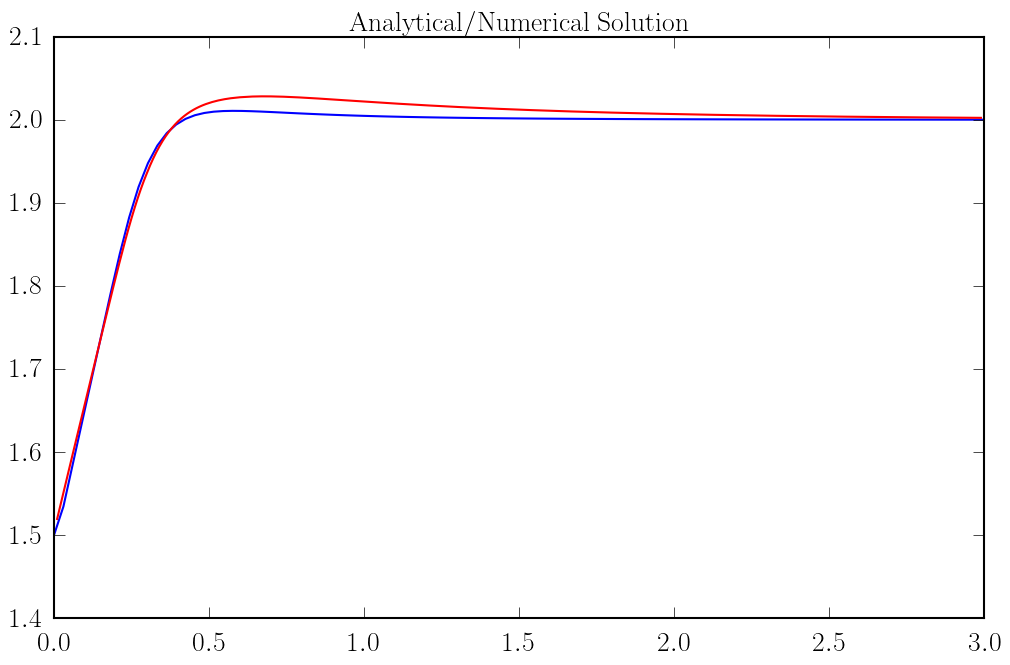

In [106]:
pl.plot(time2, np.abs(new),'b', label='$\mathrm{Analytical}$')
pl.plot(time,  np.abs(data),'r', label='$\mathrm{Numerical}$')
pl.title('$\mathrm{Analytical/Numerical}$ $\mathrm{Solution}$')

(-3, 3)

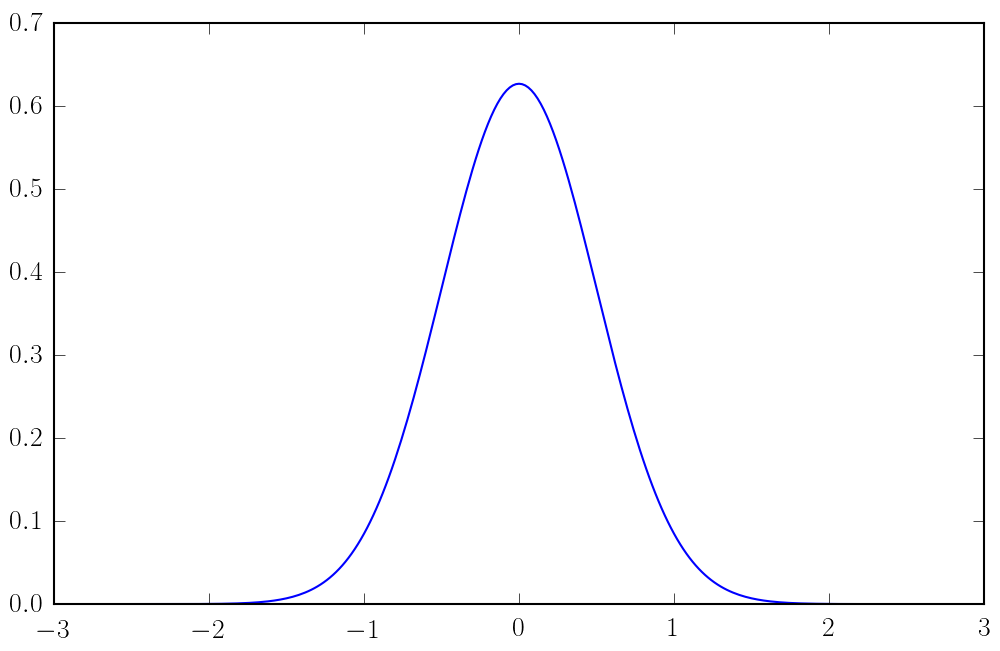

In [4]:
v = np.linspace(-20,20,2001)
f = np.sqrt(1/2*np.pi*0.25)*np.exp(-v**2/0.5)
pl.plot(v,f)
pl.xlim([-3, 3])